## Lecture 10

#### Announcements

* Midterm exam Thursday!
    * Covers material through last week
    * You can bring one double-sided 8.5x11" sheet of hand-written notes
    * Designed to take ~1hr but you have the whole class period if you need it.
* No new problems Thursday; today's Problems still due Sunday
    * but if you submit them tonight I will try to get you feedback by Thursday.
* P2: if you haven't formed a pair yet but would like to, go ahead; don't let the scary bold text about team formation deadline frighten you.

#### Goals
* Know how to resample images using forward and inverse warping (and why the latter is usually preferred)
* Know how to implement bilinear interpolation
* Be prepared to implement the full panorama stitching pipeline, including:
  * Warping images into a common coordinate system
  * Blending them with a simple linear falloff near the edges
* (576) Know align a 360° spherical panorama using a translational motion model:
  * (576) Know how to warp images onto a sphere and why they can be aligned using translation
  * (576) Know how to correct for drift to stitch a seamless 360 panorama

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Throwback Tuesday
Why did we add a ninth free parameter ($k$, the bottom right element) when solving for a homography, even though there are only 8 degrees of freedom?

What I know so far:
* Some valid homographies have a 0 in the bottom-right
* There's a numerical stability argument

What I haven't figured out:
* What do these homographies with 0 in the bottom right mean? Would you ever encounter them?
  * If you feel like thinking about this and get anywhere, let me know!


### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [x] Translation
    * [x] Affine
    * [x] Projective
    * [x] Robustness to outliers - RANSAC
* Warp image(s) into common coordinate system and blend
    * [ ] Inverse warping
    * [ ] Blending
    * [ ] 360 panoramas

### Warping: Forward and Inverse

See whiteboard notes.

Forward warping:
```
for x, y in src:
  x', y' = T(x, y)
  dst[x', y'] = src[x, y]
```

Inverse warping:
```
Tinv = np.linalg.inv(T)
for (x', y') in dst:
  x, y = Tinv(x', y')
  dst[x', y'] = src[x, y]
```

#### Bilinear Interpolation

A reasonable way to sample a floating-point pixel value from the four surrounding known pixel values.


##### First: linear interpolation.

<img src="../data/linear.png" width=600px>

##### Next: bilinear interpolation

Three equivalent interpretations:
* Weight using a tent filter centered at $(x, y)$
* Weight each corner by the area of the rectangle opposite it.
* Linearly interpolate along 2 parallel sides, then linearly interpolate again between thsoe points.

<img src="../data/bilinear.png" width=400px>




#### Other interpolation schemes

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Comparison_of_1D_and_2D_interpolation.svg/640px-Comparison_of_1D_and_2D_interpolation.svg.png)

##### Homework Problem 1

1. Complete the following function with Python-esque pseudocode (or working code in the lecture codebase), which performs inverse warping with nearest-neighbor sampling in the source image.

```python
def warp(img, tx, dsize=None)
    """ Warp img using tx, a matrix representing a geometric transformation.
    Pre: tx is 3x3 (or some upper-left slice of a 3x3 matrix). img is grayscale.
    Returns: an output image of shape dsize with the warped img"""
    H, W = img.shape[:2]

    # turn a 2x2 or 2x3 tx into a full 3x3 matrix
    txH, txW = tx.shape
    M = np.eye(3)
    M[:txH,:txW] = tx

    # set the output size to the input size if not specified
    if dsize is None:
        DH, DW = (H, W)
    else:
        DH, DW = dsize[::-1]
    out = np.zeros((DH, DW))

    # your code here
    
    return out

```


**Start with nearest-neighbor interpolation**, and test with the progressively more interesting test cases below. Once you have that working, you can try implementing bilinear interpolation if time allows.

##### Test case:

In [2]:
y1 = imageio.imread("../data/yos1.jpg").astype(np.float32) / 255
y1 = skim.color.rgb2gray(y1)

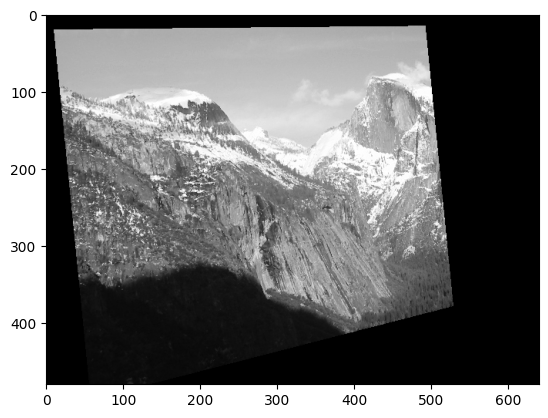

In [16]:
h, w = y1.shape

tx = np.eye(3)
tx[:2,2] = [10, 20] # translation only
tx[0,1] = 0.1 # add a shear
tx[2,0] = 0.0005 # add a perspective warp
util.imshow_gray(geometry.warp(y1, tx))

### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [x] Translation
    * [x] Affine
    * [x] Projective
    * [x] Robustness to outliers - RANSAC
* Warp image(s) into common coordinate system and blend
    * [x] Inverse warping
    * [ ] Blending
    * [ ] 360 panoramas

### Panorama Stitching Pipeline - Overview
with some blending details thrown in

(see whiteboard notes)


Somewhere in there:

##### Homework Problem 2

Suppose you are stitching a panorama with three images $I_1, I_2, I_3$ and you've fitted transformations $T_{12}$ and $T_{23}$ that map coordinates from image 1 to 2 and from 2 to 3, respectively.  Give the transformation that maps points from image 3's coordinates to image 1's coordinates.

##### Homework Problem 3

Give a strategy (describe, or write pseudocode) for finding the corners of the bounding box of a given image `img` after it has been warped using a homography `T`.